# Gaussian Unkown Mean

In [1]:
import torch
import torch.nn as nn
import torch.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim

### Specify the model with observations taken in as keyword arguments:

In [2]:
def model(prior_mean, observations={"y1": 0, "y2": 0}):
    x = pyro.sample("x", dist.Normal(prior_mean, torch.tensor(5**0.5)))
    y1 = pyro.sample("y1", dist.Normal(x, torch.tensor(2**0.5)), obs=observations["y1"])
    y2 = pyro.sample("y2", dist.Normal(x, torch.tensor(2**0.5)), obs=observations["y2"])
    return x

### And the guide, which should take the same arguments:

In [3]:
class Guide(nn.Module):
    def __init__(self):
        super(Guide, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2))

    def forward(self, prior_mean, observations={"y1": 0, "y2": 0}):
        pyro.module("guide", self)
        y1 = observations["y1"]
        y2 = observations["y2"]
        v = torch.cat((y1.view(1, 1), y2.view(1, 1)), 1)
        v = self.neural_net(v)
        mean = v[0, 0]
        std = v[0, 1].exp()
        pyro.sample("x", dist.Normal(mean, std))

guide = Guide()

### Now create a "Compiled Sequential Importance Sampling" object:
The object is initialised with the model; the guide; a PyTorch optimiser for training the guide; and the number of importance-weighted samples to draw when performing inference.

In [4]:
optimiser = pyro.optim.Adam({'lr': 1e-3})
csis = pyro.infer.CSIS(model, guide, optimiser, num_inference_samples=50)
prior_mean = torch.tensor(1.)

### Now we 'compile' the object to perform inference on this model:
The same value of `prior_mean` should be used for every compilation step and during inference.

In [5]:
for step in range(2000):
    csis.step(prior_mean)

### And now perform inference by importance sampling:

Inference is performed by importance sampling. `prior_mean` is entered again, as well as the observed values which are specified now as keyword arguments.

In [6]:
posterior = csis.run(prior_mean,
                     observations={"y1": torch.tensor(8.),
                                   "y2": torch.tensor(9.)})
marginal = pyro.infer.EmpiricalMarginal(posterior, "x")

### We now compare the posterior produced by CSIS to that performed by importance sampling from the prior:

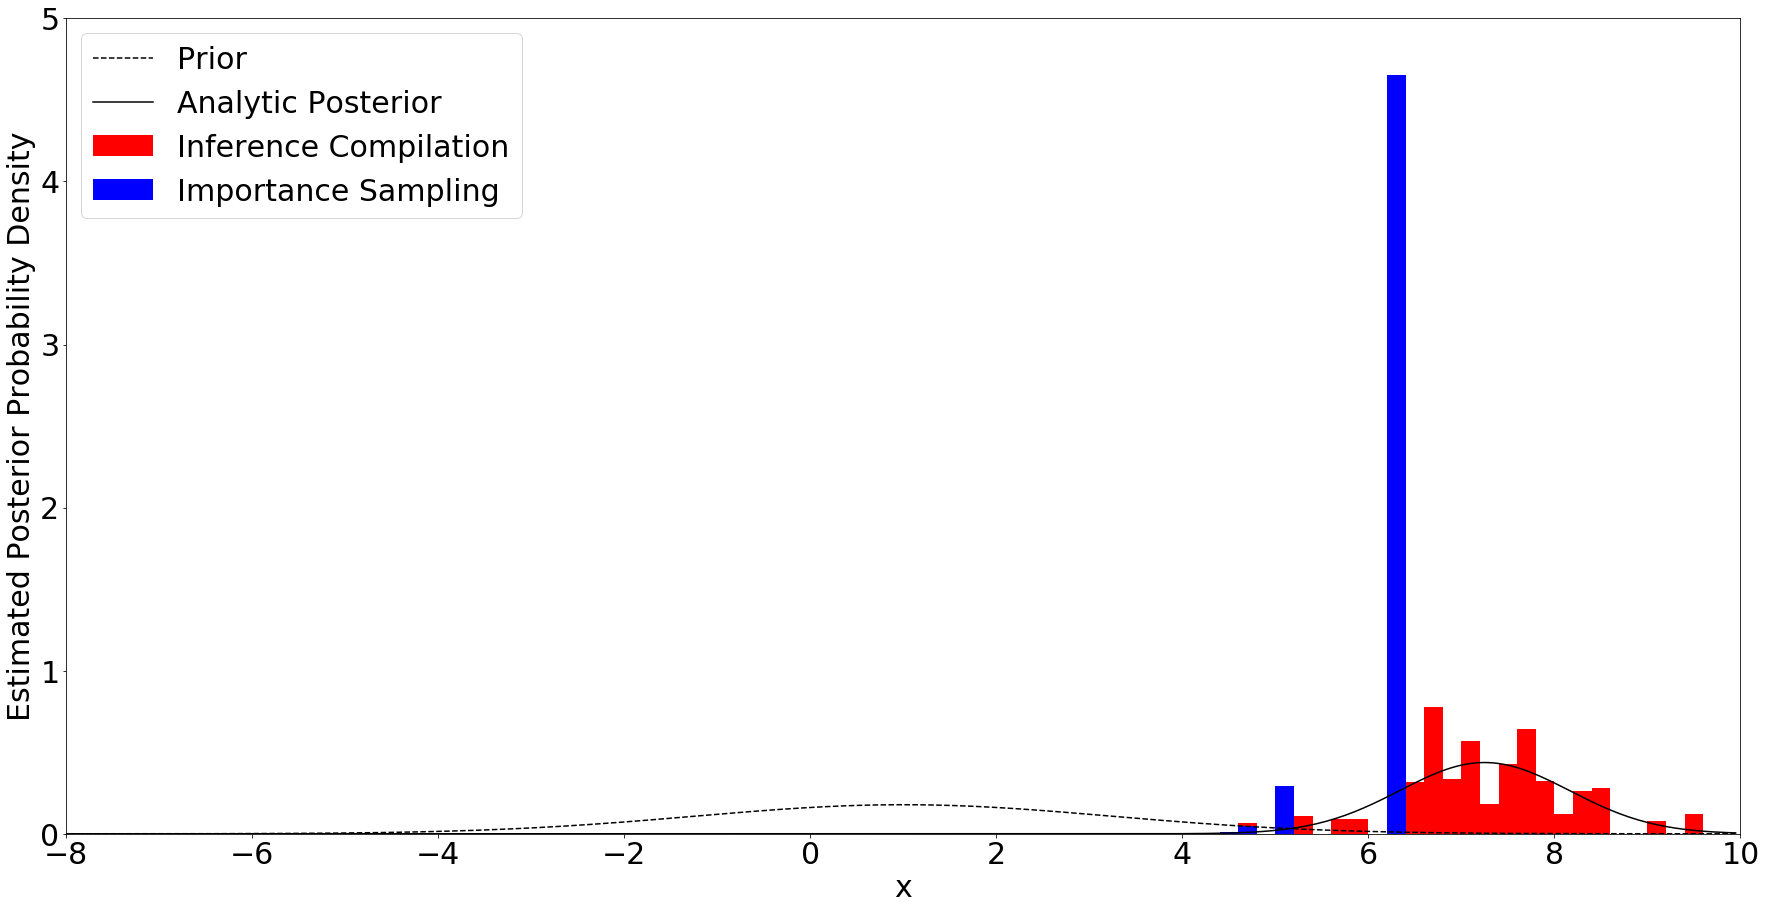

In [7]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Draw samples from empirical marginal for plotting
csis_samples = [marginal() for _ in range(1000)]

# Calculate empirical marginal with importance sampling
is_posterior = pyro.infer.Importance(model, num_samples=50).run(prior_mean,
                                                                observations={"y1": torch.tensor(8.),
                                                                              "y2": torch.tensor(9.)})
is_marginal = pyro.infer.EmpiricalMarginal(is_posterior, "x")
is_samples = [is_marginal() for _ in range(1000)]

# Calculate true prior and posterior over x
true_posterior_x = np.arange(-10, 10, 0.05)
true_posterior_y = np.array([np.exp(scipy.stats.norm.logpdf(x, loc=7.25, scale=(5/6)**0.5)) for x in true_posterior_x])
prior_x = true_posterior_x
prior_y = np.array([np.exp(scipy.stats.norm.logpdf(x, loc=1, scale=5**0.5)) for x in true_posterior_x])

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots()
plt.plot(prior_x, prior_y, 'k--', label='Prior')
plt.plot(true_posterior_x, true_posterior_y, color='k', label='Analytic Posterior')
plt.hist(csis_samples, range=(-10, 10), bins=100, color='r', normed=1, label="Inference Compilation")
plt.hist(is_samples, range=(-10, 10), bins=100, color='b', normed=1, label="Importance Sampling")
plt.xlim(-8, 10)
plt.ylim(0, 5)
plt.xlabel("x")
plt.ylabel("Estimated Posterior Probability Density")
plt.legend()
plt.show()